# Import libraries

In [25]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load dataset

In [2]:
data = "dataset/Cell_Phones_and_Accessories_5.json.gz"
df = pd.read_json(data, lines = True, compression = "gzip")
df.head()

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


In [3]:
df.columns

Index(['asin', 'image', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'style', 'summary', 'unixReviewTime', 'verified',
       'vote'],
      dtype='object')

How many reviews are verified?

In [4]:
df.groupby('verified')['unixReviewTime'].count()

verified
False    141113
True     987324
Name: unixReviewTime, dtype: int64

#### Open point: how do we address it? (If we want to do it, of course :) )
# Filtering the dataset
The first operation we will perform is the removal of punctuation characters and lowercase all letters: these operation will be useful for reducing the number of features

In [5]:
df['reviewText'] = df['reviewText'].str.replace('[.,;:;!?]+', '')

In [6]:
df['reviewText'] = df['reviewText'].str.lower()

In [7]:
X = df.reviewText[df.reviewText.notnull()].values
y = df.overall[df.reviewText.notnull()].values

In [8]:
X.shape

(1127672,)

In [9]:
y.shape

(1127672,)

How are the values split?

In [10]:
star_value, counts = np.unique(y, return_counts=True)
dict(zip(star_value, counts))

{1: 81506, 2: 57166, 3: 98214, 4: 184351, 5: 706435}

In [11]:
dict(zip(star_value, counts/len(y)))

{1: 0.07227810923743784,
 2: 0.05069381876999695,
 3: 0.08709447427975511,
 4: 0.16347927411516824,
 5: 0.6264543235976419}

Imbalanced dataset!
We'd like to split the ratings as follows:
- 1,2 and 3 will be considered negative
- 4 and 5 will be considered positive

The main reason why we'd like to proceed as follows is that, on Amazon, the most restrictive filter is the "4 star +" one and is used for filtering the returned results: a given vendor would like to have her/his products shown after this phase.

In [12]:
def int2sent(n):
    if n >= 4:
        return "positive"
    if n <= 3:
        return "negative"

In [13]:
sentiment_is_positive = y > 3

In [14]:
sentiment_categories, counts = np.unique(sentiment_is_positive, return_counts=True)
dict(zip(sentiment_categories, counts))

{False: 236886, True: 890786}

In [15]:
dict(zip(sentiment_categories, counts/len(sentiment_is_positive)))

{False: 0.2100664022871899, True: 0.7899335977128101}

# Text Preprocessing

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, sentiment_is_positive, test_size=0.33, random_state=42)

In [18]:
X_train[0]

'this case is nice well-made and fits snugly on the phone  i purchased this case along with another brand that was 100% tpu material  while i can see that this case is very scratch resistant i think i prefer a case that is 100% tpu because of improved grip and non-slip properties  the hard polycarbonate material on the back of this case will let the phone slide on a smooth surface like a table  i just prefer a case that has more of a "grippy" back so that the phone doesn\'t slide on a smooth surface  but that\'s just my preference'

In [19]:
y_train[0]

True

## Tokenization

In [21]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

Let's test the function:

In [23]:
X_train[0]

'this case is nice well-made and fits snugly on the phone  i purchased this case along with another brand that was 100% tpu material  while i can see that this case is very scratch resistant i think i prefer a case that is 100% tpu because of improved grip and non-slip properties  the hard polycarbonate material on the back of this case will let the phone slide on a smooth surface like a table  i just prefer a case that has more of a "grippy" back so that the phone doesn\'t slide on a smooth surface  but that\'s just my preference'

In [31]:
tokenized_review_test = tokenize_reviews([X_train[0]])[0]
tokenized_review_test

['this',
 'case',
 'is',
 'nice',
 'well-made',
 'and',
 'fits',
 'snugly',
 'on',
 'the',
 'phone',
 'i',
 'purchased',
 'this',
 'case',
 'along',
 'with',
 'another',
 'brand',
 'that',
 'was',
 '100',
 '%',
 'tpu',
 'material',
 'while',
 'i',
 'can',
 'see',
 'that',
 'this',
 'case',
 'is',
 'very',
 'scratch',
 'resistant',
 'i',
 'think',
 'i',
 'prefer',
 'a',
 'case',
 'that',
 'is',
 '100',
 '%',
 'tpu',
 'because',
 'of',
 'improved',
 'grip',
 'and',
 'non-slip',
 'properties',
 'the',
 'hard',
 'polycarbonate',
 'material',
 'on',
 'the',
 'back',
 'of',
 'this',
 'case',
 'will',
 'let',
 'the',
 'phone',
 'slide',
 'on',
 'a',
 'smooth',
 'surface',
 'like',
 'a',
 'table',
 'i',
 'just',
 'prefer',
 'a',
 'case',
 'that',
 'has',
 'more',
 'of',
 'a',
 '``',
 'grippy',
 "''",
 'back',
 'so',
 'that',
 'the',
 'phone',
 'does',
 "n't",
 'slide',
 'on',
 'a',
 'smooth',
 'surface',
 'but',
 'that',
 "'s",
 'just',
 'my',
 'preference']

In [32]:
#dump(X_train_tokenized, 'X_train_tokenized.joblib')
#dump(X_test_tokenized, 'X_test_tokenized.joblib')

## Stop words removal

In [33]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

Some words, however, have an important meaning for our task:

In [34]:
np.array(stopws[-36:])

array(['ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
       'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
       "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
       "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
       "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
       'wouldn', "wouldn't"], dtype='<U9')

In [35]:
stopws = stopws[:-36]

Other words with a useful meaning:

In [36]:
words2save = ["but", "while", "against", "not", "only", "very", 'don', "don't"]

Let's now create a function that removes certain stop words from a given text

In [37]:
def remove_stop_words(reviews):
    stopws = stopwords.words("english")
    #Exclude stop words with negation
    stopws = stopws[:-36]
    #Let's also keep the following words:
    words2save = ["but", "while", "against", "not", "only", "very", 'don', "don't"]
    for w in words2save:
        stopws.remove(w)
    cleaned_reviews = []
    for review in reviews:
        cleaned_review = [word for word in review if word not in stopws]
        cleaned_reviews.append(cleaned_review)
    return cleaned_reviews

Let's now test the function:

In [38]:
tokenized_review_test

['this',
 'case',
 'is',
 'nice',
 'well-made',
 'and',
 'fits',
 'snugly',
 'on',
 'the',
 'phone',
 'i',
 'purchased',
 'this',
 'case',
 'along',
 'with',
 'another',
 'brand',
 'that',
 'was',
 '100',
 '%',
 'tpu',
 'material',
 'while',
 'i',
 'can',
 'see',
 'that',
 'this',
 'case',
 'is',
 'very',
 'scratch',
 'resistant',
 'i',
 'think',
 'i',
 'prefer',
 'a',
 'case',
 'that',
 'is',
 '100',
 '%',
 'tpu',
 'because',
 'of',
 'improved',
 'grip',
 'and',
 'non-slip',
 'properties',
 'the',
 'hard',
 'polycarbonate',
 'material',
 'on',
 'the',
 'back',
 'of',
 'this',
 'case',
 'will',
 'let',
 'the',
 'phone',
 'slide',
 'on',
 'a',
 'smooth',
 'surface',
 'like',
 'a',
 'table',
 'i',
 'just',
 'prefer',
 'a',
 'case',
 'that',
 'has',
 'more',
 'of',
 'a',
 '``',
 'grippy',
 "''",
 'back',
 'so',
 'that',
 'the',
 'phone',
 'does',
 "n't",
 'slide',
 'on',
 'a',
 'smooth',
 'surface',
 'but',
 'that',
 "'s",
 'just',
 'my',
 'preference']

In [43]:
cleaned_review_test = remove_stop_words([tokenized_review_test])[0]
cleaned_review_test

['case',
 'nice',
 'well-made',
 'fits',
 'snugly',
 'phone',
 'purchased',
 'case',
 'along',
 'another',
 'brand',
 '100',
 '%',
 'tpu',
 'material',
 'while',
 'see',
 'case',
 'very',
 'scratch',
 'resistant',
 'think',
 'prefer',
 'case',
 '100',
 '%',
 'tpu',
 'improved',
 'grip',
 'non-slip',
 'properties',
 'hard',
 'polycarbonate',
 'material',
 'back',
 'case',
 'let',
 'phone',
 'slide',
 'smooth',
 'surface',
 'like',
 'table',
 'prefer',
 'case',
 '``',
 'grippy',
 "''",
 'back',
 'phone',
 "n't",
 'slide',
 'smooth',
 'surface',
 'but',
 "'s",
 'preference']

## Stemming
Because it is necessary to install Visual C++ before installing the package 'pyStemmer' via pip https://support.microsoft.com/it-it/help/2977003/the-latest-supported-visual-c-downloads I will use nltk library even though it is less efficient

In [50]:
from nltk.stem import PorterStemmer, LancasterStemmer
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

Once again let's test the function:

In [51]:
cleaned_review_test

['case',
 'nice',
 'well-made',
 'fits',
 'snugly',
 'phone',
 'purchased',
 'case',
 'along',
 'another',
 'brand',
 '100',
 '%',
 'tpu',
 'material',
 'while',
 'see',
 'case',
 'very',
 'scratch',
 'resistant',
 'think',
 'prefer',
 'case',
 '100',
 '%',
 'tpu',
 'improved',
 'grip',
 'non-slip',
 'properties',
 'hard',
 'polycarbonate',
 'material',
 'back',
 'case',
 'let',
 'phone',
 'slide',
 'smooth',
 'surface',
 'like',
 'table',
 'prefer',
 'case',
 '``',
 'grippy',
 "''",
 'back',
 'phone',
 "n't",
 'slide',
 'smooth',
 'surface',
 'but',
 "'s",
 'preference']

This is the result using the Porter Stemmer

In [52]:
porter_test = stem_reviews([cleaned_review_test])[0]
porter_test

['case',
 'nice',
 'well-mad',
 'fit',
 'snugli',
 'phone',
 'purchas',
 'case',
 'along',
 'anoth',
 'brand',
 '100',
 '%',
 'tpu',
 'materi',
 'while',
 'see',
 'case',
 'veri',
 'scratch',
 'resist',
 'think',
 'prefer',
 'case',
 '100',
 '%',
 'tpu',
 'improv',
 'grip',
 'non-slip',
 'properti',
 'hard',
 'polycarbon',
 'materi',
 'back',
 'case',
 'let',
 'phone',
 'slide',
 'smooth',
 'surfac',
 'like',
 'tabl',
 'prefer',
 'case',
 '``',
 'grippi',
 "''",
 'back',
 'phone',
 "n't",
 'slide',
 'smooth',
 'surfac',
 'but',
 "'s",
 'prefer']

Instead, if the Lancaster stemmer is chosen this is the result:

In [53]:
lancaster_test = stem_reviews([cleaned_review_test], stemmer_name='Lancaster')[0]
lancaster_test

['cas',
 'nic',
 'well-made',
 'fit',
 'snug',
 'phon',
 'purchas',
 'cas',
 'along',
 'anoth',
 'brand',
 '100',
 '%',
 'tpu',
 'mat',
 'whil',
 'see',
 'cas',
 'very',
 'scratch',
 'resist',
 'think',
 'pref',
 'cas',
 '100',
 '%',
 'tpu',
 'improv',
 'grip',
 'non-slip',
 'property',
 'hard',
 'polycarbon',
 'mat',
 'back',
 'cas',
 'let',
 'phon',
 'slid',
 'smoo',
 'surfac',
 'lik',
 'tabl',
 'pref',
 'cas',
 '``',
 'grippy',
 "''",
 'back',
 'phon',
 "n't",
 'slid',
 'smoo',
 'surfac',
 'but',
 "'s",
 'pref']

## TF-IDF
For computing TF-IDF matrix we need to rebuild the sentences: each review is a list of words while a string is needed.

In [78]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

Usual test for checking if everything works as expected

In [79]:
lancaster_test

['cas',
 'nic',
 'well-made',
 'fit',
 'snug',
 'phon',
 'purchas',
 'cas',
 'along',
 'anoth',
 'brand',
 '100',
 '%',
 'tpu',
 'mat',
 'whil',
 'see',
 'cas',
 'very',
 'scratch',
 'resist',
 'think',
 'pref',
 'cas',
 '100',
 '%',
 'tpu',
 'improv',
 'grip',
 'non-slip',
 'property',
 'hard',
 'polycarbon',
 'mat',
 'back',
 'cas',
 'let',
 'phon',
 'slid',
 'smoo',
 'surfac',
 'lik',
 'tabl',
 'pref',
 'cas',
 '``',
 'grippy',
 "''",
 'back',
 'phon',
 "n't",
 'slid',
 'smoo',
 'surfac',
 'but',
 "'s",
 'pref']

In [80]:
rebuild_reviews([lancaster_test])

["cas nic well-made fit snug phon purchas cas along anoth brand 100 % tpu mat whil see cas very scratch resist think pref cas 100 % tpu improv grip non-slip property hard polycarbon mat back cas let phon slid smoo surfac lik tabl pref cas `` grippy '' back phon n't slid smoo surfac but 's pref"]

## Compute TF-IDF matrix
For avoiding a high number of features the following two constraints will be set:
- A term should have a frequency >= 5 in the entire corpus
- Only best 50 000 features are kept

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
def create_tf_idf_matrix(X_train, X_test, min_doc_freq = 5, max_feat = 50000):
    tfidf_vect = TfidfVectorizer(min_df= min_doc_freq, max_features = max_feat)
    X_train_tfidf = tfidf_vect.fit_transform(X_train)
    X_test_tfidf = tfidf_vect.transform(X_test)
    return tfidf_vect, X_train_tfidf, X_test_tfidf

In [99]:
X_train_sample = X_train[[1,5]]
X_train_sample[0]

"perhaps i received a faulty band but mine lasted less than 48 hours and caused my smartwatch to fall of twice the first time it fell off was at home and i noticed it because the watch fell on the hardwood floor making a noise the second time i was in class teaching and it fell on carpet which i wouldn't have noticed if my student hadn't pointed it out\nthis band is a lovely color and looked great with the silver samsung gear s2 s smartwatch it is very smooth and comfortable i noticed it wasn't exactly flush against the sides of the watch from the beginning but it was so minute i didn't mind it worked perfectly the first day and a half the third day i had it is when it fell off i don't know why it no longer stayed on it looks the same on the ends yet one side pops right off it was very easy to put on and the sizing was great i did not sleep with it on and i didn't do anything that put unnecessary stress on it if there weren't so many other bands to choose just like this one i probably 

In [100]:
X_train_sample[1]

"honestly when i got this i tossed the headphones as i already have very nice headphones for my phone and i did not purchase this for that anyway  i use the square card reader to take payments on the go for my business but since upgrading to a new heavy duty case i have had to resort to 'removing' the outer case in order to use the card reader  this was very inconvenient so i started my hunt for an extension  i found this and yes - at least for my phone (samsung galaxy s2) it works perfectly with my square reader"

In [101]:
X_test_sample = X_test[[1,5]]
X_test_sample[0]

'perfect fit'

In [102]:
X_test_sample[1]

'<a data-hook="product-link-linked" class="a-link-normal" href="/blu-pure-xl-smartphone-4g-lte-gsm-unlocked-64gb-3gb-ram-grey/dp/b01612pvb8/ref=cm_cr_arp_d_rvw_txtie=utf8">blu pure xl smartphone - 4g lte gsm unlocked - 64gb +3gb ram - grey</a>the blu pure xl is amazing very fast speed and amazing screen detail the camera it amazing but does make pictures very bright low light is fantastic and focus is fast and sharp you get way more than what you pay for\n\nspeakers the dual stereo speakers are loud and clear i have to turn the phone down in order to make my ringer not be heard by the neighbors\n\nscreen screen is full 1440 and the refresh rate is high end while watching videos you\'ll be able to see pores on faces just fine and very fluid movement\n\n1 handed ability the built-in keyboard is great but swipe prediction is very pore this does have very good one handed support but i recommend replacing the keyboard app with something that has better prediction if you\'re a swipe user\n\n

In [103]:
tfidf_vect, X_train_tfidf, X_test_tfidf = create_tf_idf_matrix(X_train_sample, X_test_sample, min_doc_freq=1)

In [105]:
len(tfidf_vect.get_feature_names())

178

In [106]:
print(X_train_tfidf)

  (0, 105)	0.040311144197764756
  (0, 115)	0.040311144197764756
  (0, 39)	0.040311144197764756
  (0, 12)	0.12093343259329425
  (0, 18)	0.08604513331254271
  (0, 84)	0.040311144197764756
  (0, 73)	0.040311144197764756
  (0, 75)	0.040311144197764756
  (0, 146)	0.040311144197764756
  (0, 2)	0.040311144197764756
  (0, 61)	0.040311144197764756
  (0, 6)	0.25813539993762813
  (0, 22)	0.040311144197764756
  (0, 86)	0.11472684441672362
  (0, 135)	0.08062228839552951
  (0, 153)	0.17209026662508542
  (0, 38)	0.040311144197764756
  (0, 93)	0.08062228839552951
  (0, 156)	0.040311144197764756
  (0, 148)	0.43022566656271355
  (0, 41)	0.08062228839552951
  (0, 152)	0.08062228839552951
  (0, 69)	0.4875890887710754
  (0, 40)	0.16124457679105902
  (0, 94)	0.12093343259329425
  :	:
  (1, 114)	0.25640170450071137
  (1, 144)	0.08546723483357047
  (1, 103)	0.08546723483357047
  (1, 49)	0.08546723483357047
  (1, 17)	0.08546723483357047
  (1, 132)	0.08546723483357047
  (1, 159)	0.08546723483357047
  (1, 87)	0.

In [107]:
print(X_test_tfidf)

  (1, 174)	0.016140172660558772
  (1, 171)	0.08038706046284601
  (1, 169)	0.11298120862391142
  (1, 167)	0.016140172660558772
  (1, 166)	0.04593546312162629
  (1, 162)	0.03445159734121972
  (1, 161)	0.09187092624325258
  (1, 160)	0.04842051798167632
  (1, 159)	0.016140172660558772
  (1, 158)	0.016140172660558772
  (1, 153)	0.3330321076317906
  (1, 151)	0.21819344982772487
  (1, 149)	0.016140172660558772
  (1, 148)	0.43638689965544974
  (1, 147)	0.057419328902032864
  (1, 146)	0.032280345321117544
  (1, 137)	0.011483865780406572
  (1, 113)	0.032280345321117544
  (1, 106)	0.16140172660558774
  (1, 99)	0.016140172660558772
  (1, 98)	0.032280345321117544
  (1, 96)	0.1263225235844723
  (1, 93)	0.11298120862391142
  (1, 91)	0.13780638936487888
  (1, 89)	0.032280345321117544
  :	:
  (1, 64)	0.18374185248650515
  (1, 63)	0.12912138128447018
  (1, 61)	0.016140172660558772
  (1, 56)	0.08038706046284601
  (1, 52)	0.011483865780406572
  (1, 51)	0.016140172660558772
  (1, 50)	0.016140172660558772
 

## Merge all preprocessing functions

In [111]:
def preprocess_reviews(X_train,
                       X_test,
                       apply_tokenization=True,
                       apply_stop_words_removal=True,
                       apply_stemming=True,
                       stemmer = "Porter"):
    if apply_tokenization:
        X_train = tokenize_reviews(X_train)
        X_test = tokenize_reviews(X_test)
        print("Tokenization completed!")
    if apply_stop_words_removal:
        X_train = remove_stop_words(X_train)
        X_test = remove_stop_words(X_test)
        print("Stop words removal completed!")
    if apply_stemming:
        X_train = stem_reviews(X_train, stemmer)
        X_test = stem_reviews(X_test, stemmer)
        print("Stemming completed!")
    X_train = rebuild_reviews(X_train)
    X_test = rebuild_reviews(X_test)
    tfidf_vect, X_train, X_test = create_tf_idf_matrix(X_train, X_test)
    return tfidf_vect, X_train, X_test

# Classifiers
## Multinomial Naive-Bayes
### Porter

In [112]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
tfidf_vect, X_train_tfidf_ps, X_test_tfidf_ps = preprocess_reviews(X_train, X_test)
clf.fit(X_train_tfidf_ps, y_train)

Tokenization completed!
Stop words removal completed!
Stemming completed!


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Evaluate performances

In [113]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

In [114]:
train_score = clf.score(X_train_tfidf_ps, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ps, y_test)    # Test Accuracy
print(train_score)
print(test_score)

In [117]:
predictions = clf.predict(X_test_tfidf_ps)
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [118]:
cm

array([[ 23393,  54831],
       [  4213, 289695]], dtype=int64)

In [119]:
proba = clf.predict_proba(X_test_tfidf_ps)
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
auc_score = auc(recall, precision)
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

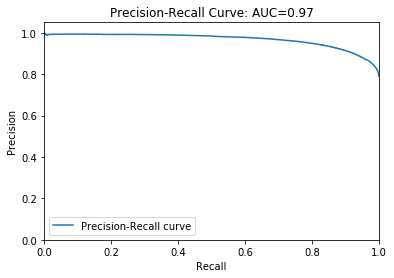

In [122]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

In [123]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.85      0.30      0.44     78224
       True       0.84      0.99      0.91    293908

avg / total       0.84      0.84      0.81    372132



### Lancaster

In [125]:
clf = MultinomialNB()
tfidf_vect, X_train_tfidf_ls, X_test_tfidf_ls = preprocess_reviews(X_train, X_test, stemmer='Lancaster')
clf.fit(X_train_tfidf_ls, y_train)

Tokenization completed!
Stop words removal completed!
Stemming completed!


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [126]:
train_score = clf.score(X_train_tfidf_ls, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ls, y_test)    # Test Accuracy
print(train_score)
print(test_score)

In [129]:
predictions = clf.predict(X_test_tfidf_ls)
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)
proba = clf.predict_proba(X_test_tfidf_ls)
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
auc_score = auc(recall, precision)
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

In [130]:
cm

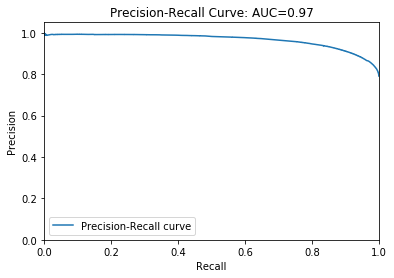

In [132]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

In [133]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.85      0.28      0.42     78224
       True       0.84      0.99      0.91    293908

avg / total       0.84      0.84      0.80    372132



## Random forest
### Porter

In [134]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_ps, y_train) # it takes around 30 minutes

building tree 1 of 50building tree 2 of 50building tree 3 of 50
building tree 4 of 50


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 25.8min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 35.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [135]:
train_score = clf.score(X_train_tfidf_ps, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ps, y_test)    # Test Accuracy

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished


In [136]:
predictions = clf.predict(X_test_tfidf_ps)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished


In [137]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.85      0.50      0.63     78224
       True       0.88      0.98      0.93    293908

avg / total       0.87      0.88      0.86    372132



Results are more encouraging! The problem is that it's way slower than Multinomial NB.
## TruncatedSVD
The X_train vector has around 20k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

In [138]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_ps_svd = tsvd.fit_transform(X_train_tfidf_ps)
X_test_tfidf_ps_svd = tsvd.transform(X_test_tfidf_ps)

In [139]:
X_train_tfidf_ps

<755540x22003 sparse matrix of type '<class 'numpy.float64'>'
	with 15891127 stored elements in Compressed Sparse Row format>

In [140]:
print("train with old features: ",np.array(X_train_tfidf_ps).shape)
print("train with new features:" ,np.array(X_train_tfidf_ps_svd).shape)

train with old features:  ()
train with new features: (755540, 500)


### Store SVD-transformed dataset

In [141]:
dump(X_train_tfidf_ps_svd, 'X_train_tfidf_ps_svd.joblib')
dump(X_test_tfidf_ps_svd, 'X_test_tfidf_ps_svd.joblib')

['X_test_tfidf_ps_svd.joblib']

### Classifiers
Multinomial NB won't be used for the following reasons: https://stackoverflow.com/questions/24169238/dealing-with-negative-values-in-sklearn-multinomialnb
#### Randomforest

In [142]:
from sklearn.naive_bayes import MultinomialNB

clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_ps_svd, y_train)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [143]:
predictions = clf.predict(X_test_tfidf_ps_svd)
print(classification_report(y_test,predictions))

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.9s finished


             precision    recall  f1-score   support

      False       0.82      0.36      0.50     78224
       True       0.85      0.98      0.91    293908

avg / total       0.85      0.85      0.82    372132



### Spell checker
It is highly probable that, in long reviews, there is at least one spelling mistakes, therefore a correct the spell errors might lead to better results. For doing so we will use pyspellchecker, which is based on Peter Norvig's blog post about building basic a spell checking algorithm

In [145]:
from spellchecker import SpellChecker
spell = SpellChecker()

In [150]:
test_words =  ['sunrise', "aternoon", "adnerstand"]
for word in test_words:
    print(spell.correction(word))

sunrise
afternoon
understand


Let's now wrap it up in a function and test it:

In [153]:
def fix_spelling_mistakes(reviews):
    spell = SpellChecker()
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word)]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [154]:
fix_spelling_mistakes(test_words)

[['understand'], ['understand'], ['understand']]

It works as expected. It is now possible to incorporate it in the preprocessing function defined before

In [155]:
def preprocess_reviews(X_train,
                       X_test,
                       apply_tokenization=True,
                       apply_spell_fix=True,
                       apply_stop_words_removal=True,
                       apply_stemming=True,
                       stemmer = "Porter"):
    if apply_tokenization:
        X_train = tokenize_reviews(X_train)
        X_test = tokenize_reviews(X_test)
        print("Tokenization completed!")
    if apply_spell_fix:
        X_train = fix_spelling_mistakes(X_train)
        X_test = fix_spelling_mistakes(X_test)
        print("Spell mistakes fixing completed!")
    if apply_stop_words_removal:
        X_train = remove_stop_words(X_train)
        X_test = remove_stop_words(X_test)
        print("Stop words removal completed!")
    if apply_stemming:
        X_train = stem_reviews(X_train, stemmer)
        X_test = stem_reviews(X_test, stemmer)
        print("Stemming completed!")
    X_train = rebuild_reviews(X_train)
    X_test = rebuild_reviews(X_test)
    tfidf_vect, X_train, X_test = create_tf_idf_matrix(X_train, X_test)
    return tfidf_vect, X_train, X_test

### MultinomialNB Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
tfidf_vect, X_train_tfidf_ps, X_test_tfidf_ps = preprocess_reviews(X_train, X_test)
clf.fit(X_train_tfidf_ps, y_train)

Tokenization completed!


In [ ]:
train_score = clf.score(X_train_tfidf_ps, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ps, y_test)    # Test Accuracy
print(train_score)
print(test_score)

In [ ]:
predictions = clf.predict(X_test_tfidf_ps)
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [ ]:
cm

In [ ]:
proba = clf.predict_proba(X_test_tfidf_ps)
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
auc_score = auc(recall, precision)
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

In [ ]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

In [ ]:
print(classification_report(y_test,predictions))